In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [2]:
torch.__version__

'1.9.0+cu102'

In [3]:
df = pd.read_csv('../data/amazon_reviews_small.csv')

In [4]:
df['review'] = df['review_headline'] + '. ' + df['review_body']

In [5]:
df['review_sentiments'] = 0

In [6]:
df['review_sentiments'][df['star_rating'].isin([4, 5])] = 1

/home/reza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
df = df.drop(columns=['Unnamed: 0', 'review_headline', 'review_body', 'star_rating'])

In [8]:
df

,review,review_sentiments
0,Good book. This is a very good book. I recomme...,1
1,the Marenon Chronically Series. Loved all thre...,1
2,GOOD READ. Made me think about the fine line b...,1
3,excellant family devotion. I had been looking ...,1
4,"Great read. So entertaining, not a dull moment...",1
...,...,...
9995,Awesome. I haven't read a book like this in a ...,1
9996,Absolutely GREAT. I started reading it because...,1
9997,Sicko. These are two writers with some serious...,0
9998,Just too small. It was just too small for the ...,0


In [9]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [10]:
df_small = stratified_sample_df(df, 'review_sentiments', 1000)

In [29]:
df_small['review_sentiments'].value_counts()

0    1000
1    1000
Name: review_sentiments, dtype: int64

In [30]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df_small['review'].tolist(), 
                                                                      df_small['review_sentiments'].tolist(), 
                                                                      stratify=df_small['review_sentiments'].tolist(), 
                                                                      test_size=0.5, 
                                                                      random_state=42)

In [31]:
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, 
                                                                  temp_labels, 
                                                                  stratify=temp_labels, 
                                                                  test_size=500, 
                                                                  random_state=42)

In [32]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /home/reza/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /home/reza/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /home/reza/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10e

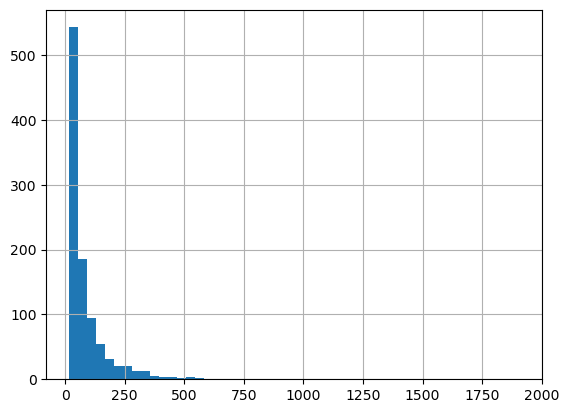

In [33]:
seq_len = [len(i.split()) for i in train_texts]
import matplotlib.pyplot as plt
pd.Series(seq_len).hist(bins = 50)
plt.show()

In [34]:
train_encodings = tokenizer(train_texts, truncation=True, 
                            padding=True, max_length = 100)
val_encodings = tokenizer(val_texts, truncation=True, 
                          padding=True, max_length = 100)
test_encodings = tokenizer(test_texts, truncation=True, 
                           padding=True, max_length = 100)

In [35]:
class AmazonReviewsDatasetSmall(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AmazonReviewsDatasetSmall(train_encodings, train_labels)
val_dataset = AmazonReviewsDatasetSmall(val_encodings, val_labels)
test_dataset = AmazonReviewsDatasetSmall(test_encodings, test_labels)

In [36]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/reza/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": f

Step,Training Loss
10,0.688300
20,0.690700
30,0.686400
40,0.688000
50,0.676200
60,0.669500
70,0.649400
80,0.614900
90,0.546900
100,0.466600




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=189, training_loss=0.4955779648331738, metrics={'train_runtime': 1668.7728, 'train_samples_per_second': 1.798, 'train_steps_per_second': 0.113, 'total_flos': 77617616400000.0, 'train_loss': 0.4955779648331738, 'epoch': 3.0})

In [38]:
trainer.is_model_parallel

False

In [39]:
test_encodings

{'input_ids': [[101, 2422, 3191, 1011, 2025, 3565, 4087, 1012, 1045, 2245, 2023, 2338, 2001, 2035, 2157, 2005, 1037, 3509, 3191, 1013, 2146, 4946, 4536, 1012, 1996, 18458, 1998, 2104, 23809, 2100, 2024, 5875, 1012, 1045, 2228, 2045, 2024, 1037, 2843, 1997, 3033, 4394, 2008, 1996, 2466, 14523, 2000, 5433, 1998, 1045, 2371, 1037, 2210, 11473, 27067, 1012, 1045, 2228, 2023, 1037, 2204, 3191, 2005, 1996, 3976, 1045, 3825, 1006, 1002, 1015, 1007, 1045, 2123, 1005, 1056, 2228, 2009, 1005, 1055, 1996, 2279, 4602, 6547, 2021, 2017, 2180, 1005, 1056, 2022, 3565, 9364, 1012, 102, 0, 0, 0, 0, 0, 0, 0], [101, 2038, 2307, 4784, 1012, 2009, 3957, 2307, 7547, 2592, 1012, 2036, 1010, 3640, 2592, 2006, 8434, 2070, 9440, 4030, 1998, 2000, 7374, 2070, 2005, 1996, 3020, 8915, 8737, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 22

In [42]:
test_seq = torch.tensor(test_encodings['input_ids'])
test_mask = torch.tensor(test_encodings['attention_mask'])
test_y = torch.tensor(test_labels)

In [43]:
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))

In [51]:
from torch import nn
pt_preds = nn.functional.softmax(preds.logits, dim=-1)

In [54]:
np_preds = np.argmax(pt_preds, axis = 1)
print(classification_report(np.array(test_labels), np_preds))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       250
           1       0.88      0.77      0.82       250

    accuracy                           0.83       500
   macro avg       0.84      0.83      0.83       500
weighted avg       0.84      0.83      0.83       500



In [55]:
pd.crosstab(np.array(test_labels), np_preds)

col_0,0,1
row_0,,
0,223,27
1,57,193


In [34]:
# freeze all the parameter
for param in bert.parameters():
    param.requires_grad = False

In [103]:
class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        
        super(BERT_Arch, self).__init__()
        
        self.bert = bert
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # relu activation function
        self.relu =  nn.ReLU()
        
        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)
        
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)
        
    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        
        x = self.fc1(cls_hs)
        
        x = self.relu(x)
        
        x = self.dropout(x)
        
        # output layer
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)
        
        return x

In [104]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# push the model to CPU
model = model.to(device)

Using cpu device


In [105]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [106]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1. 1.]


In [107]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)

weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [108]:
# function to train the model
def train():
    
    model.train()
    
    total_loss, total_accuracy = 0, 0
    
    # empty list to save model predictions
    total_preds=[]
    
    # iterate over batches
    for step, batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
            
        # push the batch to device
        batch = [r.to(device) for r in batch]  
        sent_id, mask, labels = batch
        # clear previously calculated gradients 
        model.zero_grad()
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
            
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
        
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
        
    #returns the loss and predictions
    return avg_loss, total_preds

In [109]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
    
    # deactivate dropout layers
    model.eval()
    
    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []
    
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
            
        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        
        sent_id, mask, labels = batch
        
        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)
            
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            
            total_loss = total_loss + loss.item()
            
            preds = preds.detach().cpu().numpy()
            
            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [110]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 0.728
Validation Loss: 0.655

 Epoch 2 / 10

Evaluating...

Training Loss: 0.639
Validation Loss: 0.620

 Epoch 3 / 10

Evaluating...

Training Loss: 0.589
Validation Loss: 0.571

 Epoch 4 / 10

Evaluating...

Training Loss: 0.565
Validation Loss: 0.558

 Epoch 5 / 10

Evaluating...

Training Loss: 0.569
Validation Loss: 0.566

 Epoch 6 / 10

Evaluating...

Training Loss: 0.541
Validation Loss: 0.526

 Epoch 7 / 10

Evaluating...

Training Loss: 0.613
Validation Loss: 0.540

 Epoch 8 / 10

Evaluating...

Training Loss: 0.551
Validation Loss: 0.530

 Epoch 9 / 10

Evaluating...

Training Loss: 0.523
Validation Loss: 0.748

 Epoch 10 / 10

Evaluating...

Training Loss: 0.619
Validation Loss: 0.605


In [111]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [112]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [113]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       250
           1       0.77      0.75      0.76       250

    accuracy                           0.76       500
   macro avg       0.76      0.76      0.76       500
weighted avg       0.76      0.76      0.76       500



In [114]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,193,57
1,63,187
